In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import torchvision
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [26]:
# load in train and test
train_data_csv = pd.read_csv("./data/sign_mnist_train.csv")
test_data_csv = pd.read_csv("./data/sign_mnist_test.csv")

In [9]:
# convert data to np arrays 
train_data = np.array(train_data_csv, dtype="float32")
test_data = np.array(test_data_csv, dtype="float32")

In [15]:
# 27k training cases; 7k test cases
print(train_data.shape)
print(test_data.shape)

(27455, 785)
(7172, 785)


In [16]:
# Include J and Z technically, but there won't be any data associated with them
classes =  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y'] # not including the last letter for reduced computation. Not going to remove J for continuity in the indices, however

Label:  O


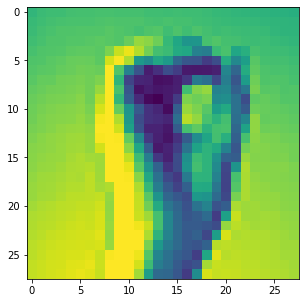

In [24]:
# Sample image display
num = random.randint(1, train_data.shape[0])
fig, ax = plt.subplots(figsize=(5, 5))
plt.imshow(train_data[num, 1:].reshape((28, 28)))
print("Label: ", classes[int(train_data[num, 0])])

Text(0.5, 1.0, 'Label Distributions')

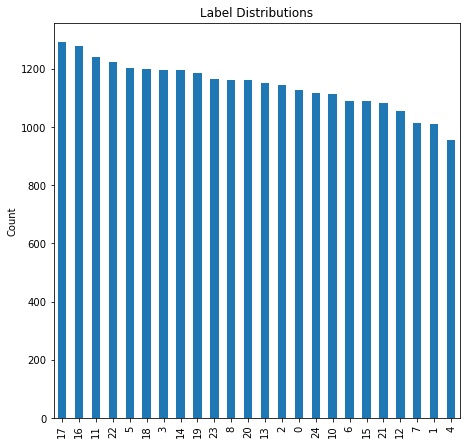

In [27]:
# Let's try something cool with the data
fig = plt.figure(figsize = (16, 16))
ax1 = fig.add_subplot(221)
train_data_csv['label'].value_counts().plot(kind='bar', ax=ax1)
# DISTRIBUTIONS of labels, look at x-axis for label indices
ax1.set_ylabel('Count')
ax1.set_title("Label Distributions")

In [31]:
# Leaving this cell for PyTorch DataLoader initialization
# TODO Recalculate our means and standard deviations for the channels of our images, if necessary
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))
])
# first set is for means, second is for standard deviations. Im pretty sure we have to calculate them, but let's see if it works okay without lol

In [ ]:
# TODO Write custom DataSet class for our MNIST dataset and then use DataLoader for easy use later in training use

In [32]:
# TODO Modify this for our train_data and test_data

batch_size = 4 # Keep for now

# Creates an iterable for training dataset
# Issue is that the np array we pass in is not organized in a way that train_loader can use, so we may have to reshape our train and test arrays
# I need to step away for a moment, see if you can figure out how we can reshape the numpy arrays to be similar to cifar10 LMAO OKAY GOOGLE HOW TO RESHAPE ARRAYS Okay brb+

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

# Creates an iterable for testing dataset
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [33]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # This is where a lot of the design process will happen since we have to decide layers and such
        # The current values need to be adjusted; we don't have to immediately go for the most complex one, we should just try to get the program running
        # with a simple model before we try to make it more complex.
        self.conv1 = nn.Conv2d(3, 6, 5) # The first two values are the number of input channels (3, since we are using images)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, len(classes)) # the last int here has to be equal to the number of classes we are classifying for
    # Onwards!
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

In [34]:
# ONWARDS!
# Initialize optimizer and loss function
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [35]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data 
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Ready for Tums!')

ValueError: too many values to unpack (expected 2)

In [ ]:
PATH = './tums_net.pth'
torch.save(net.state_dict(), PATH)